### Watanabe-Akaike Information Criterion (WAIC)

* AKA Widely Available IC
* meaningless for a single model, used for model
    * evaluation & comparison
    * selection
    * ensemble averaging
* related to Kullback-Leibler divergence
* measure of distance of computed posterior distribution from "true distribution"
* requires probability distribution for each prediction

In [40]:
import pathlib
import warnings
import matplotlib.pyplot as pl

In [41]:
warnings.filterwarnings('ignore')
vz.style.use('arviz-darkgrid')

In [3]:
nc_path = pathlib.Path('../PickleJar/Results/nc_inference/')
nc_files = list(nc_path.glob('*.nc'))

In [4]:
nc_files

[PosixPath('../PickleJar/Results/NC_files/hswi_inference.nc'),
 PosixPath('../PickleJar/Results/NC_files/hs_inference.nc'),
 PosixPath('../PickleJar/Results/NC_files/hs_inference_w_ppc.nc'),
 PosixPath('../PickleJar/Results/NC_files/bn_inference_w_ppc.nc'),
 PosixPath('../PickleJar/Results/NC_files/hswi_inference_w_ppc.nc'),
 PosixPath('../PickleJar/Results/NC_files/bn_inference.nc')]

In [5]:
import arviz as vz
hs_inference = vz.from_netcdf(nc_path / 'hs_inference_w_ppc.nc')
hswi_inference = vz.from_netcdf(nc_path / 'hswi_inference_w_ppc.nc')
bnn_inference = vz.from_netcdf(nc_path / 'bn_inference_w_ppc.nc')

In [42]:
df_compare = vz.compare(dict(horseshoe=hs_inference,
                             hshoe_wi=hswi_inference,
                             BNN=bnn_inference));

In [43]:
df_compare

,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
bayesnet,-150.397,24.706,0,1,15.1036,0,True,deviance
hshoe_wi,-70.8816,32.5505,79.5151,4.28251e-08,18.0505,14.0948,True,deviance
horseshoe,-26.2162,9.67634,124.181,2.7828e-11,19.8647,16.517,True,deviance


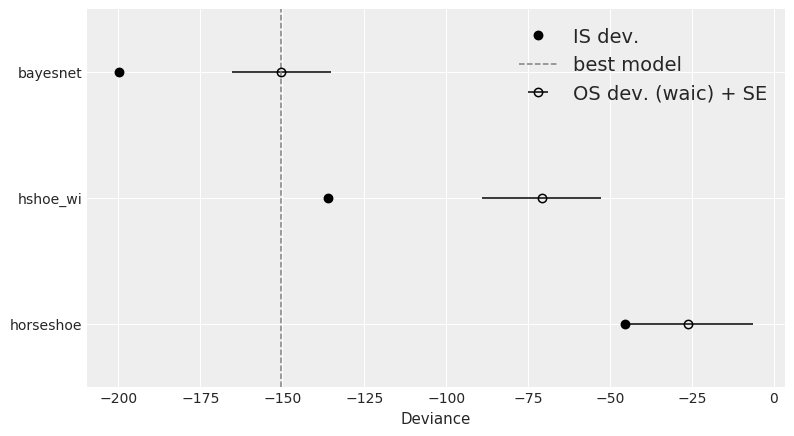

In [56]:
f, ax = pl.subplots(figsize=(9, 5))
vz.plot_compare(df_compare, ax=ax, plot_ic_diff=False)
ax.legend(['IS dev.', 'best model', 'OS dev. (waic) + SE'])
f.savefig('../FigJar/waic_comp.png', dpi=300)

<img src='../FigJar/waic_comp.png?:2'>

In [ ]:
home = pathlib.Path.home()
root = home / 'DEV-ALL/BAYES/rethinking_2ndEd/rethinking-Experimental/data'

### Computing WAIC
* Two parts: 
* Log Pointwise Predictive Density ($lppd$): <br>
$\ \ \ \rightarrow$ sum of log probability score, for each obs. $i$
<br>
$\ \ \ \rightarrow lppd(y, \Theta) = \sum_i log \frac{1}{S} \sum_s p(y_i|\Theta_s)$;  $s$ is posterior sample
* $lppd$ not enough$\rightarrow$ like $R^2$, increases with model complexity
 
* Penalty term ($p\_waic$); estimate of overfitting tendency:<br>
$\ \ \ \rightarrow$ sum of variance in log probability for each obs. $i$ <br>
$\ \ \ \rightarrow \sum_i var_\Theta(log(p(y_i|\Theta)))$
<br>
* $WAIC(y, \Theta) = -2(lppd - p\_waic)$

In [ ]:
import pandas as pd
df = pd.read_csv(root / 'cars.csv')
X = df.speed.values
Y = df.dist.values 

In [9]:
import pymc3 as pm
with pm.Model() as m:
    α = pm.Normal('α', 0, 100)
    β = pm.Normal('β', 0, 10)
    σ = pm.Uniform('σ', 0, 30)
    μ = α + β * X
    dist = pm.Normal('dist', mu=μ, sd=σ, observed=Y)
    post = pm.sample(1000, tune=1200, random_seed=42)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, β, α]
Sampling 4 chains: 100%|██████████| 8800/8800 [00:03<00:00, 2855.44draws/s]


In [10]:
render = pm.model_to_graphviz(m)
render.format = 'png'
render.render('simple_model', directory='./');

<center><img src='./simple_model.png' /></center>

In [38]:
from scipy.special import logsumexp
import scipy.stats as stats
import numpy as np
np.random.RandomState(42)

# get posterior prediction of mean regression
μ_post = post['α'].reshape(1, -1) \
         + post['β'].reshape(1, -1) \
         * X.reshape(-1, 1)
# get "s", number of samples
n_samples = μ_post.shape[1]
# sample from log_likelihood
log_likelihood = stats.norm.logpdf(Y.reshape(-1, 1),
                       loc=μ_post, 
                       scale=post['σ'].reshape(1, -1))
# compute lppd
lppd = logsumexp(log_likelihood, axis=1) - np.log(n_samples)
# compute p_waic
my_p_waic = np.var(log_likelihood, axis=1)
# compute waic
my_waic = -2 * (lppd.sum() - my_p_waic.sum())
# "black box waic"
waic = vz.waic(post, );

In [39]:
np.testing.assert_almost_equal(waic.waic, my_waic, decimal=10)
np.testing.assert_almost_equal(waic.p_waic, my_p_waic.sum(), decimal=10)